# Sourcing and Analyzing Time Series Data


### This data set is from the "Bitcoin Data Insights" data set. This is "daily, one day-delayed data showing essential insights of various Bitcoin metrics, as presented by the Blockchain website." Here I am looking at the daily bitcoin market price in USD.

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time-series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data

In [1]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key

nasdaqdatalink.ApiConfig.api_key = 'GJSNTUxZundcL9Z68cV3'

In [3]:
data = nasdaqdatalink.get_table('QDL/BCHAIN', code='MKPRU')

In [4]:
data.head()

,code,date,value
None,,,
0,MKPRU,2024-02-29,62498.79
1,MKPRU,2024-02-28,57075.01
2,MKPRU,2024-02-27,54529.54
3,MKPRU,2024-02-26,51727.76
4,MKPRU,2024-02-25,51559.99


## 2. Subsetting, wrangling, and cleaning time-series data

In [5]:
data.columns

Index(['code', 'date', 'value'], dtype='object')

In [6]:
data.shape

(5536, 3)

In [7]:
data.isnull().sum()

code     0
date     0
value    0
dtype: int64

In [8]:
data.tail()

,code,date,value
None,,,
5531,MKPRU,2009-01-06,0.0
5532,MKPRU,2009-01-05,0.0
5533,MKPRU,2009-01-04,0.0
5534,MKPRU,2009-01-03,0.0
5535,MKPRU,2009-01-02,0.0


#### Since this is daily data going all the way back to 2009, I will make a smaller subset of just 2022 to present.

In [9]:
# Subsetting data

data_sub = data.loc[(data['date'] >= '2022-01-01')]

In [10]:
data_sub.head()

,code,date,value
None,,,
0,MKPRU,2024-02-29,62498.79
1,MKPRU,2024-02-28,57075.01
2,MKPRU,2024-02-27,54529.54
3,MKPRU,2024-02-26,51727.76
4,MKPRU,2024-02-25,51559.99


In [11]:
data_sub.shape

(789, 3)

In [12]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['date'], axis=1, inplace=True)
data_sub.head()

,code,value
datetime,,
2024-02-29,MKPRU,62498.79
2024-02-28,MKPRU,57075.01
2024-02-27,MKPRU,54529.54
2024-02-26,MKPRU,51727.76
2024-02-25,MKPRU,51559.99


In [13]:
type(data_sub)

pandas.core.frame.DataFrame

In [14]:
data_sub.columns

Index(['code', 'value'], dtype='object')

In [15]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 789 entries, 2024-02-29 to 2022-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   code    789 non-null    object 
 1   value   789 non-null    float64
dtypes: float64(1), object(1)
memory usage: 18.5+ KB


TypeError: unhashable type: 'numpy.ndarray'

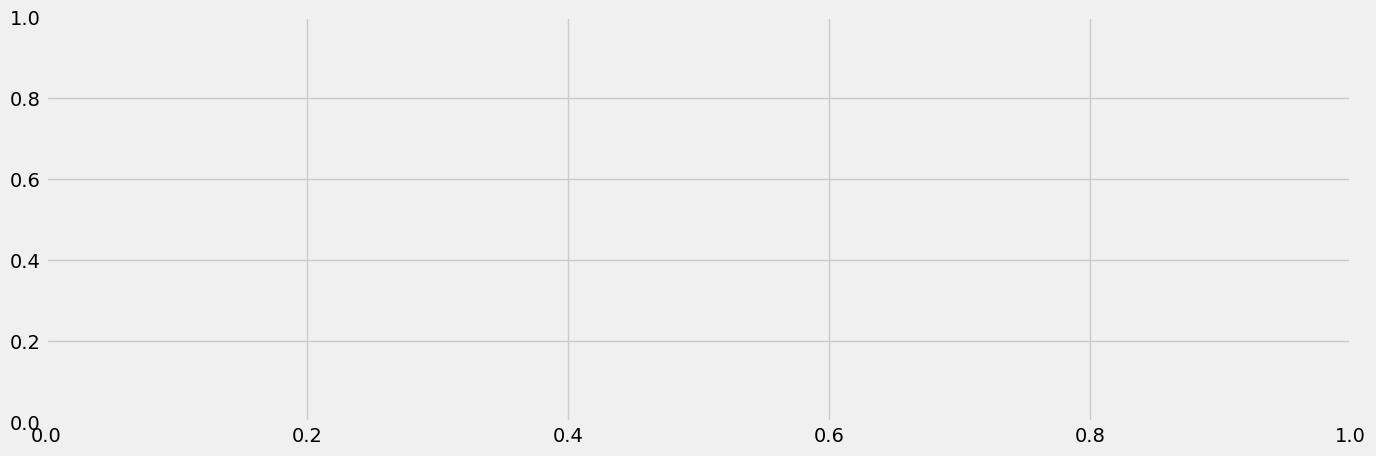

In [16]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

### Perhaps if I remove the 'code' column the plot will work

In [16]:
# Exclude the 'code' column 

exclude = 'code'
df = data_sub.drop(columns=[exclude])

print(df)

               value
datetime            
2024-02-29  62498.79
2024-02-28  57075.01
2024-02-27  54529.54
2024-02-26  51727.76
2024-02-25  51559.99
...              ...
2022-01-05  45862.98
2022-01-04  46441.99
2022-01-03  47327.87
2022-01-02  47763.33
2022-01-01  46249.56

[789 rows x 1 columns]


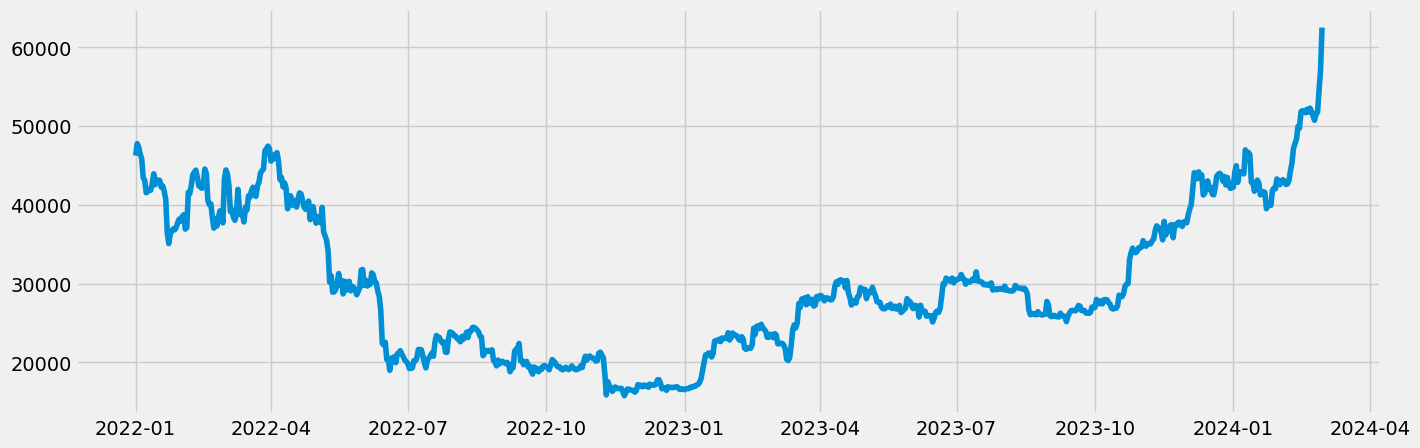

In [17]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df)

### 3. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df, model='additive')

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [19]:
# I received help from ChatGPT and a tutor to resolve the error above.

# Decompose the time series using an additive model with the specified period
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=12)

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

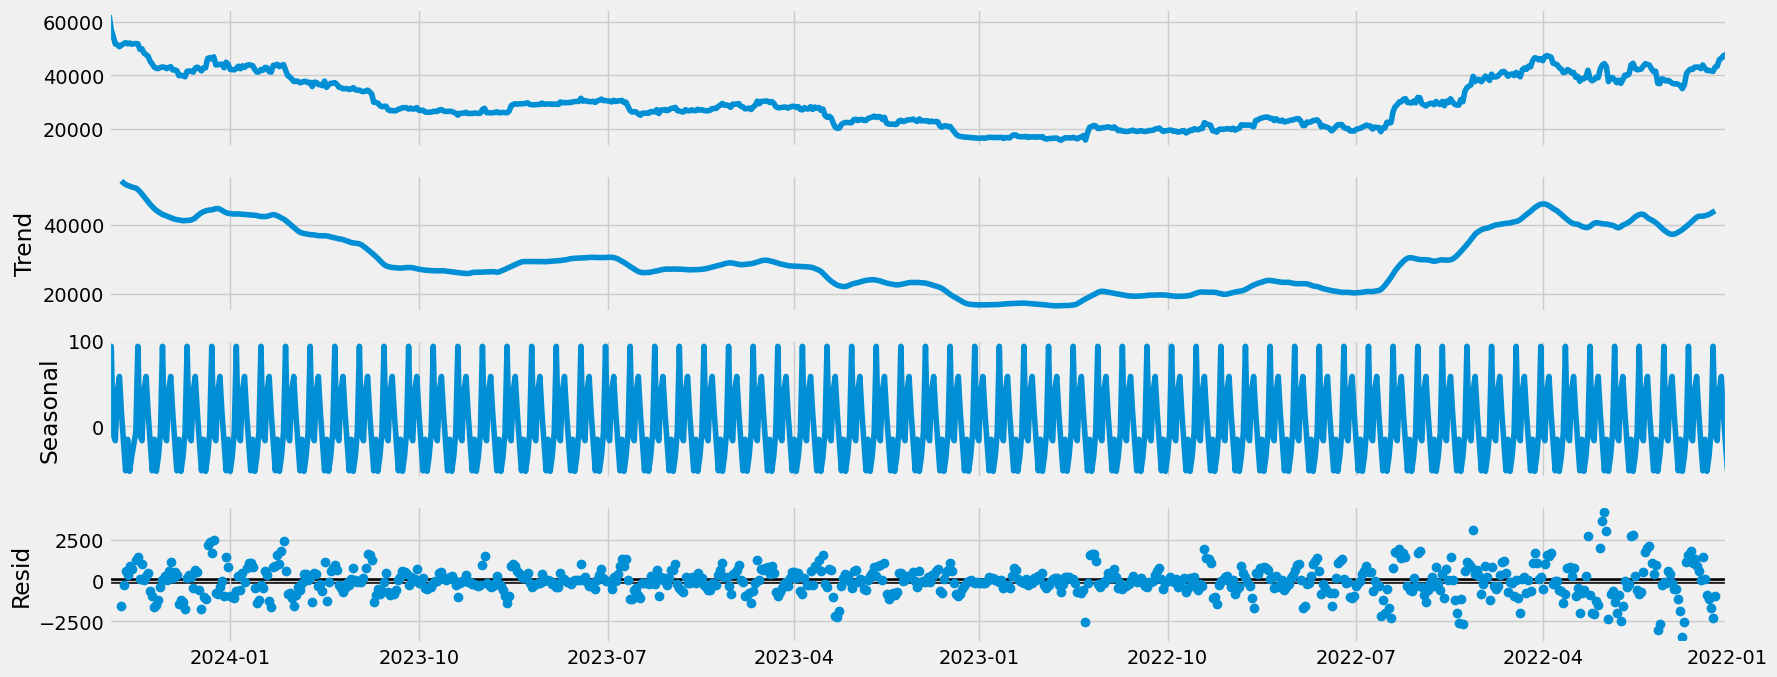

In [21]:
# Plot the separate components

decomposition.plot()
plt.show()

### The trend line, the second from the top, shows a trend of a downward bitcoin value from early 2022 to early 2023, then the line trends back up to end in 2024 slightly above where it started in 2022.
### The seasonality shows seasonal fluctuations every couple of months. The presence of a trend and seasonality indicates that this is non-stationary data.
### The final plot is the residual data after the trend and seasonality have been extracted. Most of thost data points hover around a mean of zero, varying a bit at the beginning and end of the time series where the bitcoin values were higher.


## 4. Testing for stationarity using Dickie-Fuller test

In [21]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.975882
p-value                          0.297247
Number of Lags Used             10.000000
Number of Observations Used    778.000000
Critical Value (1%)             -3.438783
Critical Value (5%)             -2.865262
Critical Value (10%)            -2.568752
dtype: float64


### Null Hypothesis = that there is no unit root. The fact that the test statistic is larger than any of the critical values indicates that there is a unit root and we cannot reject the null hypothesis. Therefore the data is non-stationary. I'll verify this by looking for autocorrelations.

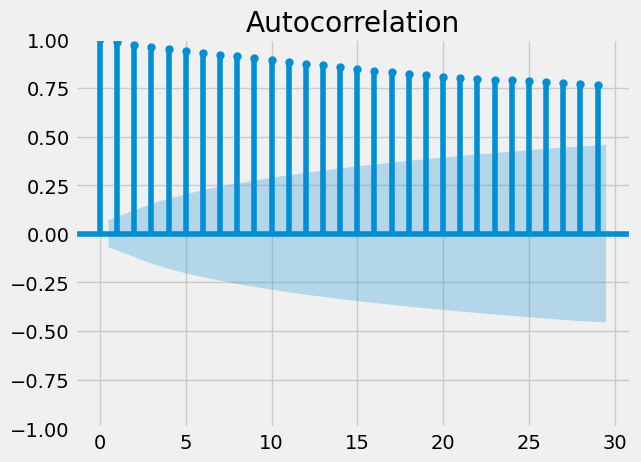

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(df)
plt.show()

### This time series has lags that are significantly correlated with each other as seen by the bars above the blue confidence interval area. This again shows that the time series is non-stationary.

## 5. Stationarizing the data

In [23]:
# Stationarizing using differencing

data_diff = df - df.shift(1)

In [24]:
# Remove the missing values that result from differencing.

data_diff.dropna(inplace = True)

In [25]:
data_diff.head()

,value
datetime,
2024-02-28,-5423.78
2024-02-27,-2545.47
2024-02-26,-2801.78
2024-02-25,-167.77
2024-02-24,-832.33


In [26]:
data_diff.columns

Index(['value'], dtype='object')

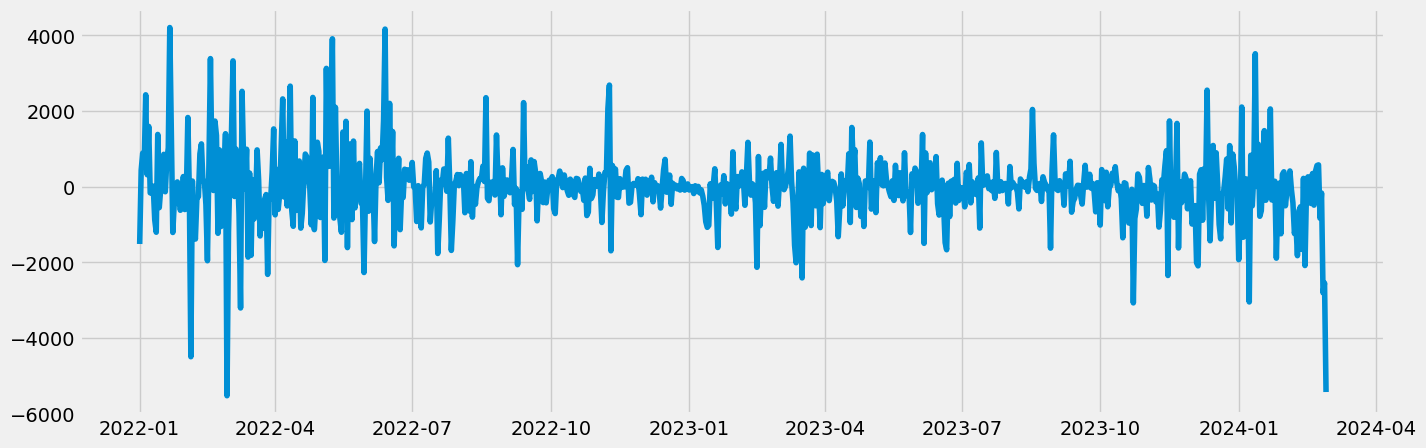

In [27]:
# How did the differencing change the time-series curve?

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

## Rerunning the Dickie-Fuller test

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.999413e+00
p-value                        6.559112e-15
Number of Lags Used            9.000000e+00
Number of Observations Used    7.780000e+02
Critical Value (1%)           -3.438783e+00
Critical Value (5%)           -2.865262e+00
Critical Value (10%)          -2.568752e+00
dtype: float64


## Now the test statistic is smaller than the 5% critical value (or any of the critical values). The p-value is 0.000000000000006559112 (in real numbers) and so is below 0.05. Now I can reject the null hypothesis and consider the data stationary.

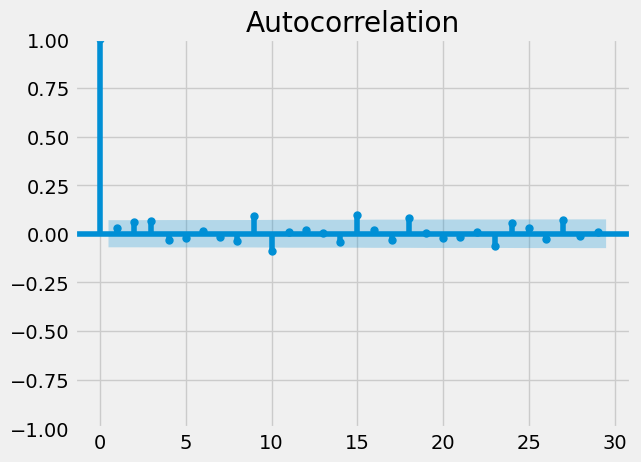

In [30]:
# Check plot again for autocorrelations

plot_acf(data_diff)
plt.show()

### The above autocorrelation chart shows that the autocorrelations are now very minimal, and the data has very strong stationarity.